In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

import phase1_preprocessor

# --- CONFIGURATION ---
# Dataset root (must contain category folders like 'Gravity Falls')
DATASET_ROOT = "Jigsaw Puzzle Dataset/Gravity Falls"

# Ground Truth images (the 'correct' folder)
GROUND_TRUTH_DIR = os.path.join(DATASET_ROOT, "correct")

# Where Phase 2 solver saved solutions
SOLVER_OUTPUT_DIR = "solved_puzzles/processed_dataset/Gravity Falls"

# Where Phase 1 saved the pieces
PHASE1_OUTPUT_DIR = "processed_dataset"

# Display Settings
plt.rcParams['figure.figsize'] = [15, 10]

def load_rgb(path):
    """Helper to load image in RGB for Matplotlib. Returns None if missing."""
    if not path or not os.path.exists(path):
        return None
    img = cv2.imread(path)
    if img is None:
        return None
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def find_ground_truth_path(puzzle_id):
    """Find ground-truth file for a puzzle id (supports png/jpg/jpeg)."""
    for ext in (".png", ".jpg", ".jpeg"):
        p = os.path.join(GROUND_TRUTH_DIR, f"{puzzle_id}{ext}")
        if os.path.exists(p):
            return p
    # fallback: recursive search under dataset root
    pattern = os.path.join(DATASET_ROOT, "**", "correct", f"{puzzle_id}.*")
    cands = glob.glob(pattern, recursive=True)
    return cands[0] if cands else None

def find_processed_puzzle_folder(puzzle_id, grid_size=None):
    """Find Phase 1 output folder for a puzzle id (optionally scoped to a grid size)."""
    if grid_size is not None:
        folder_type = f"puzzle_{grid_size}x{grid_size}"
        pattern = os.path.join(PHASE1_OUTPUT_DIR, "**", folder_type, f"puzzle_{puzzle_id}")
    else:
        pattern = os.path.join(PHASE1_OUTPUT_DIR, "**", f"puzzle_{puzzle_id}")
    cands = sorted(glob.glob(pattern, recursive=True))
    return cands[0] if cands else None

print("Setup Complete. Ready to validate.")
print(f"GROUND_TRUTH_DIR: {GROUND_TRUTH_DIR}")
print(f"SOLVER_OUTPUT_DIR: {SOLVER_OUTPUT_DIR}")
print(f"PHASE1_OUTPUT_DIR: {PHASE1_OUTPUT_DIR}")

Setup Complete. Ready to validate.
GROUND_TRUTH_DIR: Jigsaw Puzzle Dataset/Gravity Falls\correct
SOLVER_OUTPUT_DIR: solved_puzzles/processed_dataset/Gravity Falls
PHASE1_OUTPUT_DIR: processed_dataset


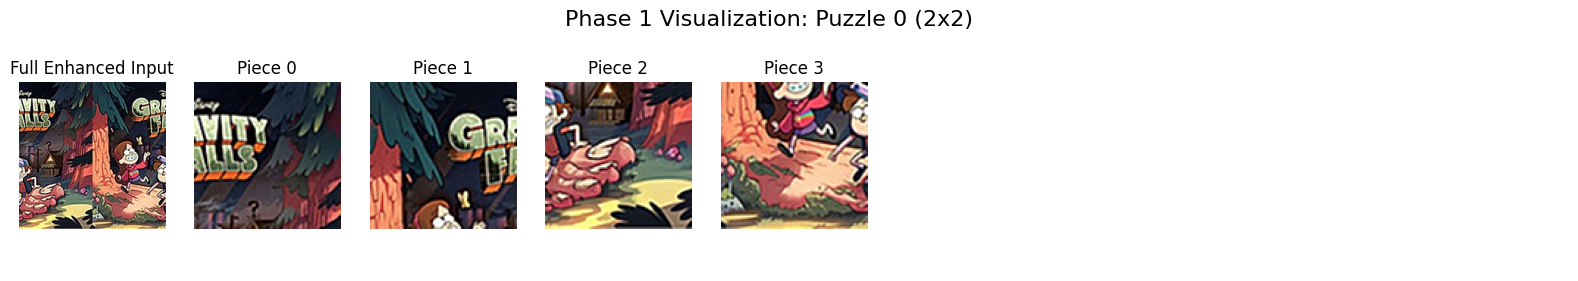

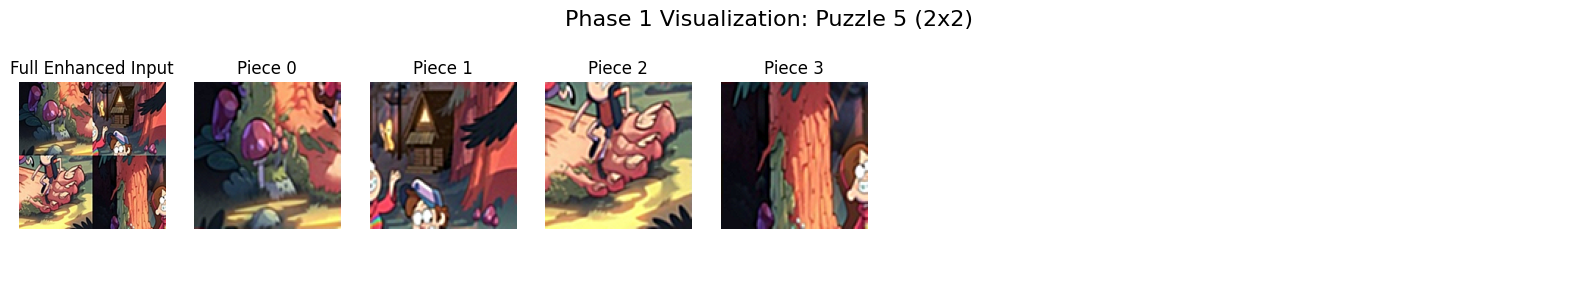

In [26]:
def visualize_phase_1(puzzle_name, grid_size=8):
    """
    Visualizes the raw input vs the extracted/enhanced pieces.
    puzzle_name:  "0" or "5"
    grid_size:  4 or 8
    """
    # Locate Phase 1 output folder for this puzzle & grid size
    target_folder = find_processed_puzzle_folder(puzzle_name, grid_size=grid_size)
    if not target_folder:
        print(f"Could not find Phase 1 output for puzzle_{puzzle_name} ({grid_size}x{grid_size})")
        return

    # Load Full Enhanced Reference
    full_ref_path = os.path.join(target_folder, "full_enhanced.jpg")
    full_img = load_rgb(full_ref_path)

    # Load First 8 Pieces
    pieces = []
    for i in range(8):
        p_path = os.path.join(target_folder, f"piece_{i:03d}.png")
        pieces.append(load_rgb(p_path))

    # Plot
    fig, axes = plt.subplots(1, 9, figsize=(20, 3))

    # Show Full Reference
    if full_img is not None:
        axes[0].imshow(full_img)
        axes[0].set_title("Full Enhanced Input")
    else:
        axes[0].text(0.5, 0.5, "Ref Not Found", ha='center')
    axes[0].axis('off')

    # Show Individual Pieces
    for i, p_img in enumerate(pieces):
        if p_img is not None:
            axes[i+1].imshow(p_img)
            axes[i+1].set_title(f"Piece {i}")
            axes[i+1].axis('off')
            # Add a border to show they are separate assets
            for spine in axes[i+1].spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(2)
        else:
            axes[i+1].axis('off')

    plt.suptitle(f"Phase 1 Visualization: Puzzle {puzzle_name} ({grid_size}x{grid_size})", fontsize=16)
    plt.show()

# Run Demo
visualize_phase_1(puzzle_name="0", grid_size=2)
visualize_phase_1(puzzle_name="5", grid_size=2)


--- VALIDATION: Sampling 10 per Category ---


==================== CATEGORY: puzzle_2x2 (110 found) ====================
Puzzle 81: 100.0%
Puzzle 77: 100.0%
Puzzle 80: 99.9%
Puzzle 43: 100.0%
Puzzle 108: 100.0%
Puzzle 75: 100.0%
Puzzle 28: 99.9%
Puzzle 5: 99.8%
Puzzle 30: 21.6%
Puzzle 51: 99.6%


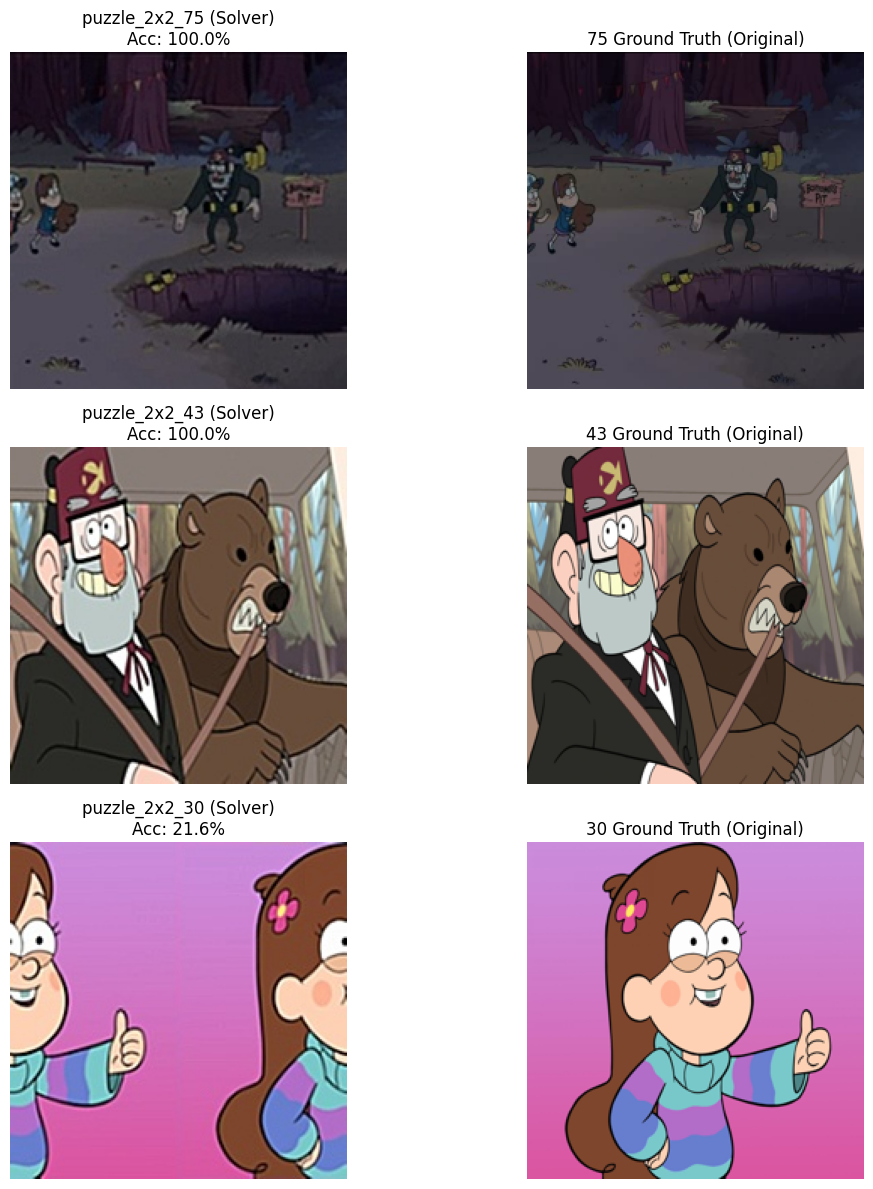



==================== CATEGORY: puzzle_4x4 (110 found) ====================
Puzzle 7: 98.8%
Puzzle 96: 98.0%
Puzzle 88: 98.9%
Puzzle 67: 39.7%
Puzzle 79: 98.9%
Puzzle 6: 46.7%
Puzzle 87: 98.7%
Puzzle 63: 98.5%
Puzzle 78: 38.7%
Puzzle 107: 99.1%


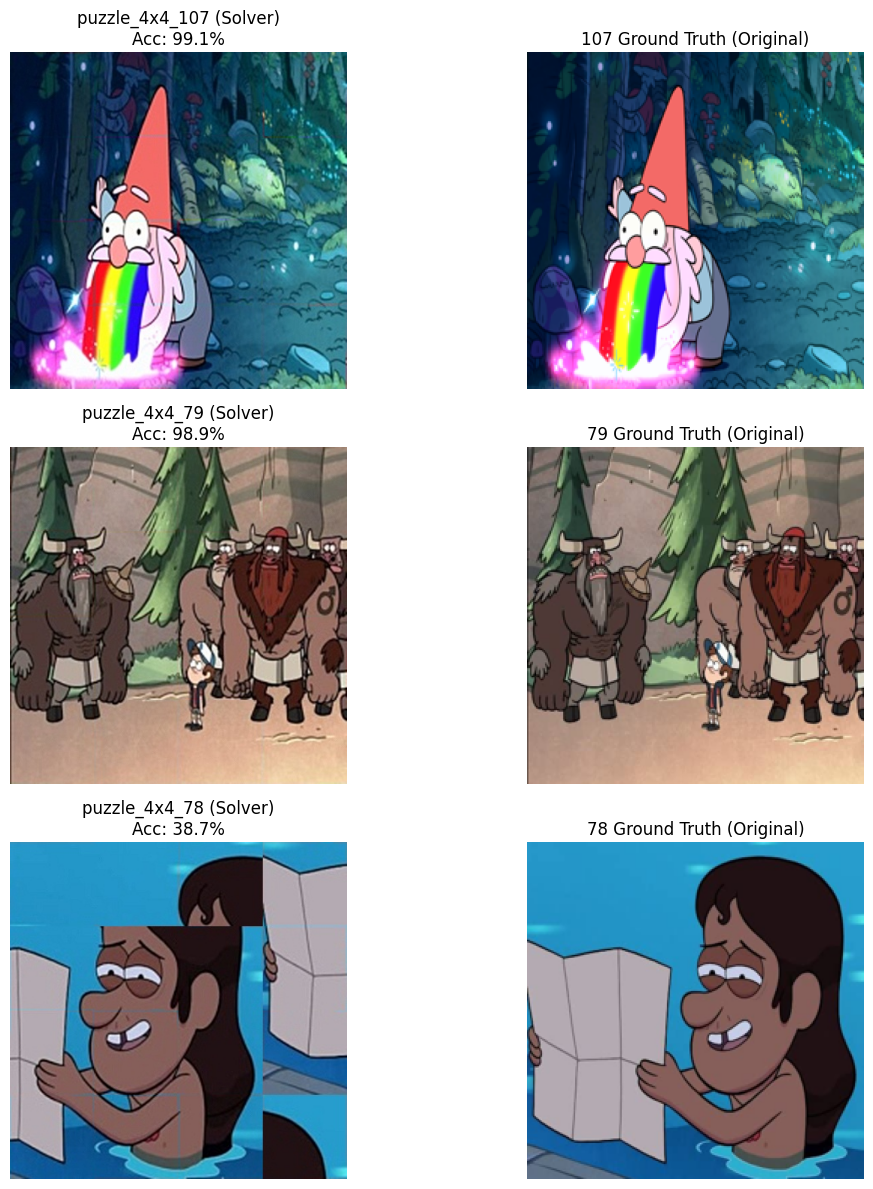



==================== CATEGORY: puzzle_8x8 (110 found) ====================
Puzzle 57: 48.4%
Puzzle 47: 22.7%
Puzzle 91: 65.8%
Puzzle 72: 28.5%
Puzzle 73: 42.1%
Puzzle 29: 43.9%
Puzzle 65: 96.4%
Puzzle 31: 61.1%
Puzzle 68: 28.0%
Puzzle 24: 47.9%


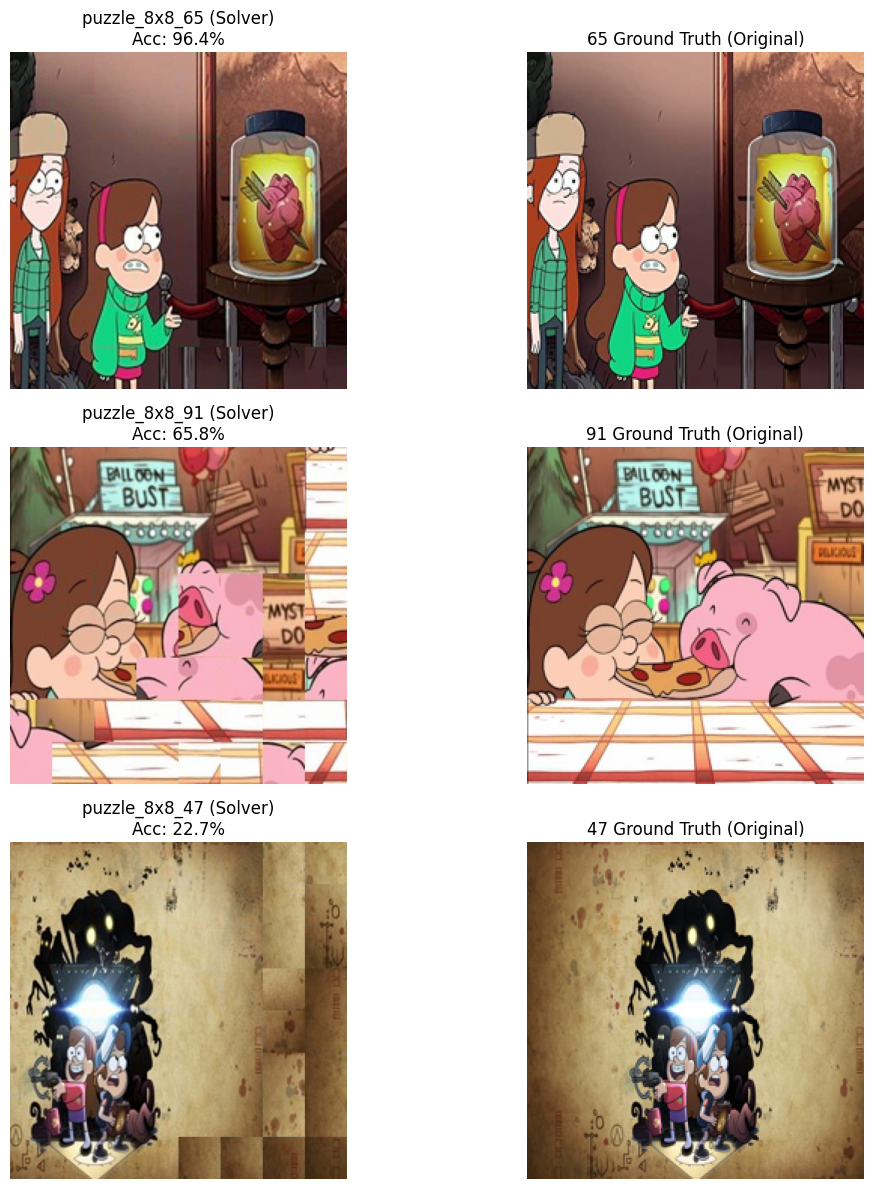

In [27]:
import random

SAMPLE_SIZE = 10  # Number of puzzles to validate per category

def enhance_ground_truth(image_rgb):
    """
    Applies Phase 1 enhancement pipeline to Ground Truth for fair comparison.
    Phase 1 enhancement expects BGR (cv2.imread output), so we convert.
    """
    if image_rgb is None:
        return None
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    enhanced_bgr = phase1_preprocessor.enhance_image(image_bgr)
    return cv2.cvtColor(enhanced_bgr, cv2.COLOR_BGR2RGB)

def calculate_accuracy(pred_img, gt_img):
    if pred_img is None or gt_img is None:
        return 0.0
    h, w, _ = pred_img.shape

    # 1. Resize GT to match prediction
    gt_resized = cv2.resize(gt_img, (w, h), interpolation=cv2.INTER_AREA)

    # 2. Enhance GT using Phase 1 enhancer
    gt_final = enhance_ground_truth(gt_resized)

    # 3. Compare (pixel-wise closeness after enhancement)
    diff = cv2.absdiff(pred_img, gt_final)
    gray_diff = cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)

    correct_pixels = np.sum(gray_diff < 30)
    return (correct_pixels / gray_diff.size) * 100

def validate_and_visualize():
    print(f"--- VALIDATION: Sampling {SAMPLE_SIZE} per Category ---")

    # 1. Find all solutions
    all_solutions = glob.glob(os.path.join(SOLVER_OUTPUT_DIR, "**", "solved.jpg"), recursive=True)
    if not all_solutions:
        print("No solutions found.")
        return

    # 2. Group by Category (2x2, 4x4, 8x8)
    categories = {"puzzle_2x2": [], "puzzle_4x4": [], "puzzle_8x8": []}

    for f in all_solutions:
        for cat in categories.keys():
            if cat in f:
                categories[cat].append(f)
                break

    # 3. Process each category
    for cat_name, files in categories.items():
        if not files:
            continue

        print(f"\n\n{'='*20} CATEGORY: {cat_name} ({len(files)} found) {'='*20}")

        # Random Sample
        sample_files = random.sample(files, min(len(files), SAMPLE_SIZE))
        results = []

        for sol_path in sample_files:
            # Extract ID
            parts = sol_path.split(os.sep)
            puzzle_id = next((p[7:] for p in parts if p.startswith("puzzle_") and p[7:].isdigit()), None)
            if not puzzle_id:
                continue

            pred_img = load_rgb(sol_path)

            gt_path = find_ground_truth_path(puzzle_id)
            gt_img = load_rgb(gt_path) if gt_path else None

            if gt_img is None:
                print(f"Puzzle {puzzle_id}: GT Not Found")
                continue

            acc = calculate_accuracy(pred_img, gt_img)
            results.append((puzzle_id, acc, pred_img, gt_img))
            print(f"Puzzle {puzzle_id}: {acc:.1f}%")

        # 4. Visualize this Category
        if results:
            # Show top 2 best and 1 worst from this sample
            results.sort(key=lambda x: x[1], reverse=True)
            to_show = results[:2] + [results[-1]] if len(results) >= 3 else results

            fig, axes = plt.subplots(len(to_show), 2, figsize=(12, 4 * len(to_show)))
            if len(to_show) == 1:
                axes = [axes]  # Handle single case

            for i, (pid, score, pred, gt) in enumerate(to_show):
                axes[i][0].imshow(pred)
                axes[i][0].set_title(f"{cat_name}_{pid} (Solver)\nAcc: {score:.1f}%")
                axes[i][0].axis('off')

                axes[i][1].imshow(gt)
                axes[i][1].set_title(pid + " Ground Truth (Original)")
                axes[i][1].axis('off')

            plt.tight_layout()
            plt.show()

# Run
validate_and_visualize()